In [ ]:
import jax
import matplotlib.pyplot as plt
from jax import lax, vmap

In [10]:
import jax.numpy as jnp

In [11]:
g = lambda x, y, z: jnp.sin(x) + jnp.cos(y) + jnp.abs(z)

In [12]:
dgdrv = vmap(jax.grad(g, argnums=(0, 1, 2)), (0, None, None), 0)


In [13]:
xv = jnp.linspace(-10, 10, 100)

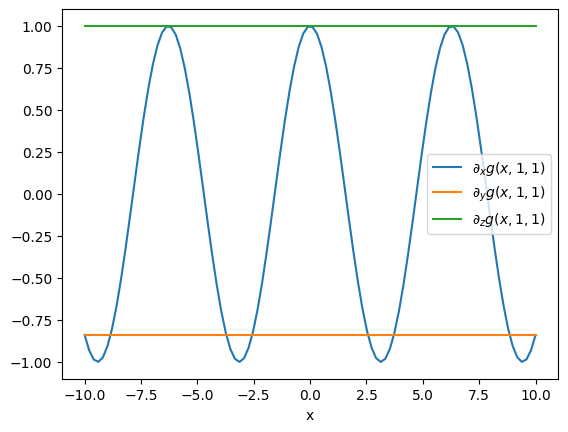

In [14]:
dd = dgdrv(xv, 1.0, 1.0)
plt.plot(xv, dd[0], label=r"$\partial_x g(x,1,1)$")
plt.plot(xv, dd[1], label=r"$\partial_y g(x,1,1)$")
plt.plot(xv, dd[2], label=r"$\partial_z g(x,1,1)$")
plt.xlabel("x")
plt.legend()

In [15]:
def f(x, y):
    return jnp.dot(x, y)

In [16]:
x = jnp.linspace(0, 1, 11)
y = jnp.linspace(1, 2, 11)
f(x, y)  # → DeviceArray(9.35, dtype=float32)
jax.grad(f, argnums=0)(x, y)

Array([1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
       1.6      , 1.7      , 1.8      , 1.9      , 2.       ],      dtype=float32)

In [17]:
X = jnp.linspace(0, 1, 55).reshape(5, 11)
vmap(jax.grad(f, argnums=0), (0, None), 0)(X, y)  # → DeviceArray([[1. ...)

Array([[1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9      , 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9      , 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9      , 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9      , 2.       ],
       [1.       , 1.1      , 1.2      , 1.3      , 1.4000001, 1.5      ,
        1.6      , 1.7      , 1.8      , 1.9      , 2.       ]],      dtype=float32)

In [18]:
print(len(X))

5


In [19]:
def u(x, A):
    return jnp.log(A + x)


In [20]:
from jax import grad, vmap

In [21]:
def dARA(xarr, A):
    den = grad(grad(u, argnums=(0)), argnums=(0))
    bun = grad(u, argnums=(0))
    g = lambda x, A: -den(x, A) / bun(x, A)
    h = vmap(grad(g, argnums=(0)), (0, None), 0)
    return h(xarr, A)


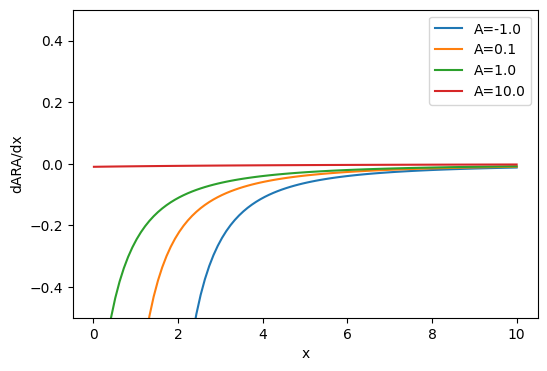

In [22]:
Aarr = [-1.0, 0.1, 1.0, 10.0]
flg = plt.figure(figsize=(6, 4))
for A in Aarr:
    xarr = jnp.linspace(0.01, 10.0, 100)
    darr = dARA(xarr, A)
    plt.plot(xarr, darr, label=f"A={A}")
plt.xlabel("x")
plt.ylabel("dARA/dx")
plt.ylim(-0.5, 0.5)
plt.legend()

In [24]:
from jax.lax import scan

In [25]:
def f(x, null):
    x = 1.0 / (1.0 + x)
    return x, null

In [26]:
def g(x0):
    x, _ = scan(f, x0, None, length=3)
    return x

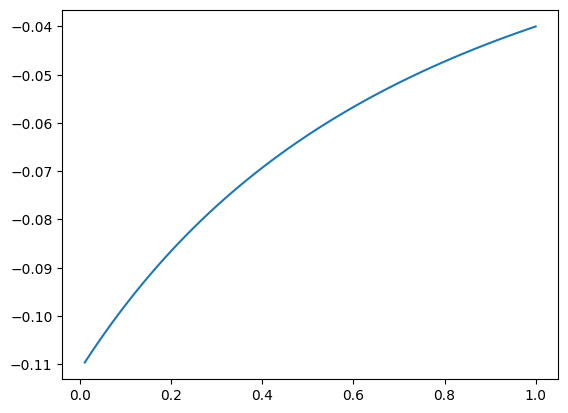

In [27]:
from jax import jit

h = jit(vmap(grad(g)))
xarr = jnp.linspace(0.01, 1.0, 100)
darr = h(xarr)
plt.plot(xarr, darr)

In [ ]:
def em_step(carry, _):
    xt, yt, current_key = carry
    key_dW, next_key_for_loop = jax.random.split(current_key)

    A_val = self.A_func(xt, yt, theta_2_val)
    B_val = self.B_func(xt, yt, theta_1_val)
    H_val = self.H_func(xt, yt, theta_3_val)

    dW = jax.random.normal(key_dW, (r,)) * jnp.sqrt(dt)
    diffusion_term = jnp.dot(B_val, dW)

    xt_next = xt + A_val * dt + diffusion_term
    yt_next = yt + H_val * dt

    return (xt_next, yt_next, next_key_for_loop), (xt_next, yt_next)


initial_carry = (x0_val, y0_val, key)

# lax.scan uses the Python int total_steps_for_scan_py for its length
final_carry, (x_results, y_results) = lax.scan(
    em_step, initial_carry, None, length=total_steps_for_scan_py
)

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax, random


def simulate_heston(
    s0: float,
    v0: float,
    mu: float,
    kappa: float,
    theta: float,
    xi: float,
    rho: float,
    dt: float,
    n_steps: int,
    seed: int = 0,
):
    """Heston モデルの Euler–Maruyama シミュレーション。

      dS_t = mu * S_t * dt + sqrt(v_t) * S_t * dW1_t
      dv_t = kappa*(theta - v_t) * dt + xi * sqrt(v_t) * dW2_t
      corr(dW1_t, dW2_t) = rho * dt

    Args:
        s0, v0 : 初期スポットと初期ボラティリティ
        mu     : ドリフト
        kappa  : ボラの平均回帰速度
        theta  : ボラの平均回帰レベル
        xi     : ボラのボラ
        rho    : 相関係数
        dt     : タイムステップ幅
        n_steps: ステップ数
        seed   : 乱数シード

    Returns:
        (S_path, v_path) : ともに shape=(n_steps+1,) の jnp.ndarray

    """
    key = random.PRNGKey(seed)
    sqrt_dt = jnp.sqrt(dt)

    # 相関を持つ正規乱数を生成するための 2x2 下三角行列
    chol = jnp.array([[1.0, 0.0], [rho, jnp.sqrt(1.0 - rho**2)]])

    def step(carry, _):
        S_t, v_t, key = carry

        key, subkey = random.split(key)
        z = random.normal(subkey, shape=(2,))
        dW1, dW2 = chol @ z  # 相関付きブラウン運動の増分
        dW1 *= sqrt_dt
        dW2 *= sqrt_dt

        # ボラティリティは 0 以下にならないように制御
        v_sqrt = jnp.sqrt(jnp.maximum(v_t, 0.0))

        v_next = v_t + kappa * (theta - v_t) * dt + xi * v_sqrt * dW2
        v_next = jnp.maximum(v_next, 0.0)  # 非負に保つ

        S_next = S_t + mu * S_t * dt + v_sqrt * S_t * dW1

        return (S_next, v_next, key), (S_next, v_next)

    # lax.scan 用の初期値
    carry0 = (jnp.array(s0), jnp.array(v0), key)

    # scan
    _, paths = lax.scan(step, carry0, None, length=n_steps)

    S_path = jnp.concatenate([jnp.array([s0]), paths[0]])
    v_path = jnp.concatenate([jnp.array([v0]), paths[1]])

    return S_path, v_path


# --- 動作テスト ---
if __name__ == "__main__":
    params = dict(
        s0=100.0,
        v0=0.04,
        mu=0.04,
        kappa=1.5,
        theta=0.04,
        xi=0.3,
        rho=-0.7,
        dt=1 / 252,
        n_steps=252,
        seed=123,
    )

    S, v = simulate_heston(**params)
    print("S_path shape:", S.shape)
    print("v_path shape:", v.shape)
    print("最初の5ステップ:")
    print("S:", S[:5])
    print("v:", v[:5])


S_path shape: (253,)
v_path shape: (253,)
最初の5ステップ:
S: [100.        99.02963   96.78759   95.89168   95.589775]
v: [0.04       0.03792151 0.04145629 0.0447992  0.04288536]


## 第7章 NumPyroでマルコフ連鎖モンテカルロを試す

微分可能プログラミング本の第7章では、JAXベースの確率的プログラミング言語であるNumPyroを使い、HMC-NUTSでベイズ推論を行う方法を丁寧に解説しています。ここでは章の流れに沿って、正弦波データの曲線フィットを題材にした典型的なワークフローをまとめ直し、手元で再現できるようにしています。

- HMC / NUTS の役割とウォームアップの重要性
- `numpyro.sample` によるモデル記述と事前分布の設定
- ArviZ を利用したサンプルの健全性チェック
- 事後予測分布から HPDI (Highest Posterior Density Interval) を求める手順
- カスタム勾配や補間関数など、第7章後半の発展的トピックにつながる観点のメモ


### 曲線フィットの設定とデータ生成式

観測データは
$$y_i = \sin(x_i + \phi) + \varepsilon_i, \qquad \varepsilon_i \sim \mathcal{N}(0, \sigma)$$
の形で生成すると仮定する。以下のコードではサンプルサイズ $N=20$ の $\{(x_i, y_i)\}$ を擬似的に作る。

In [39]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import arviz as az

plt.style.use("bmh")

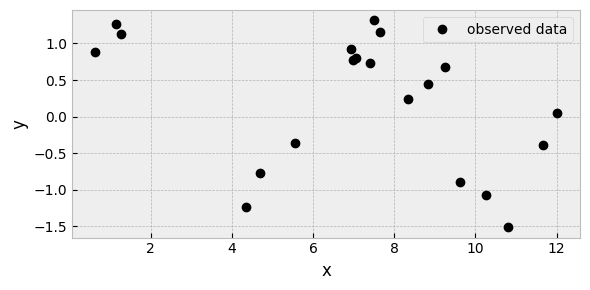

In [58]:
np.random.seed(32)
phase_true = 0.5
sigma_true = 0.3
num_points = 20
x_obs = np.sort(np.random.rand(num_points)) * 4 * np.pi
y_obs = np.sin(x_obs + phase_true) + np.random.normal(0.0, sigma_true, size=num_points)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_obs, y_obs, "o", color="black", label="observed data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
fig.tight_layout()

#### NumPyro モデル記述の見取り図

NumPyro では `numpyro.sample(name, dist, obs=None)` を順に呼ぶことで、見かけの乱数生成コードがそのまま joint measure $\mu(dx_1, \dots, dx_n)$ を定義します。
- `obs` を省いた呼び出しは $x_i = \texttt{sample}(\text{name}_i, \texttt{dist}_i)$ の形で潜在変数を導入し、事前の要素として積み上げる。
- `obs` に観測データを渡すと、その変数は固定されて $\log p(x_i \mid x_{<i})$ の項だけがモデルの対数尤度に足し込まれる。

結果として joint $\mu(dx_1, \dots, dx_n)$ と、観測済み変数で条件付けた正則条件付き確率（ベイズ的には尤度と同値） $\rho(dx_1, \dots, dx_n \mid x_{\text{obs}})$ を同じモデル関数の中で同時に記述できます。以下では具体的な事前分布と尤度をこのスタイルで与える。

### 事前分布と尤度

推定するパラメータ $\phi$ と $\sigma$ に対して
$$\phi \sim \mathcal{U}(-\pi, \pi), \qquad \sigma \sim \mathrm{Exponential}(1)$$
と置き、観測モデルを
$$y_i \mid \phi, \sigma \sim \mathcal{N}\bigl(\sin(x_i + \phi),\, \sigma\bigr)$$
とする。次のセルで NumPyro モデルを定義する。
なお `numpyro.sample(name, dist, obs=None)` は「名前付きの確率変数」を宣言するプリミティブで、`obs` を省けば事前分布 `dist` から乱数が生成されてその値が戻り、`obs` に観測値を渡すと乱数生成は行われず、その値を固定して対数尤度項だけが足し込まれる。

In [59]:
def sinusoid_model(x, y=None):
    phase = numpyro.sample("phase", dist.Uniform(-jnp.pi, jnp.pi))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mean = jnp.sin(x + phase)
    numpyro.sample("y", dist.Normal(mean, sigma), obs=y)

### HMC-NUTS によるサンプリング

NumPyro の NUTS カーネルで事後分布 $p(\phi, \sigma \mid \mathbf{y})$ を近似する。
ウオームアップ $1000$、本番サンプル $2000$ といった設定に対応するコードを以下で実行する。

- コードが生成する `MCMC` インスタンスと `NUTS` カーネルの役割を説明
- `mcmc.run(...)` に渡す `x`, `y` がモデル引数にどのように接続されるかを解説
- 実行後の `mcmc.get_samples()`・`mcmc.get_extra_fields()` が「直近の `run` で得た事後サンプルにアクセスする窓口」になり、別の `run` を呼ぶまでは同じ辞書を返すこと
- まず `NUTS(model_function, **kernel_kwargs)` のようにモデリング関数をカーネルでラップし、そのカーネルを `MCMC` に渡す——という順番が NumPyro のお作法。`MCMC(NUTS(sinusoid_model), num_warmup=..., num_samples=...)` のように内側で `NUTS` を生成してもよいが、「カーネル → MCMC → run」という構造を守ることで、別カーネルへの切り替えや共通設定の再利用が容易になる。

`NUTS(sinusoid_model)` で作ったカーネルを `MCMC` に渡すと、`mcmc` オブジェクトは「どのモデルをどのアルゴリズムで回すか」を知っている状態になります。ただしデータ (`x_obs`, `y_obs`) はまだバインドされておらず、`mcmc.run(rng_key, x=..., y=...)` を呼んだときに初めて `sinusoid_model` の引数 `x`, `y` として渡されます。`run` の第1引数は乱数キー、それ以降はモデル関数のパラメータ名と一致させて指定する形です。`run` が完了すると、`mcmc` インスタンス内部に事後サンプルや診断統計が保存され、`print_summary()` や `get_samples()`、そして `az.plot_trace(az.from_numpyro(mcmc), ...)` のような可視化コマンドで利用できるようになります。新しいデータや乱数で再度 `run` を呼ぶと過去のサンプルは上書きされるので、別の実験を走らせる前に必要ならサンプルを外部にコピーしておくと安心です。

sample: 100%|██████████| 1400/1400 [00:00<00:00, 1411.87it/s, 3 steps of size 8.64e-01. acc. prob=0.87]




                mean       std    median      5.0%     95.0%     n_eff     r_hat
     phase      0.34      0.12      0.34      0.14      0.52    850.68      1.00
     sigma      0.34      0.06      0.33      0.24      0.42    871.51      1.00

Number of divergences: 0


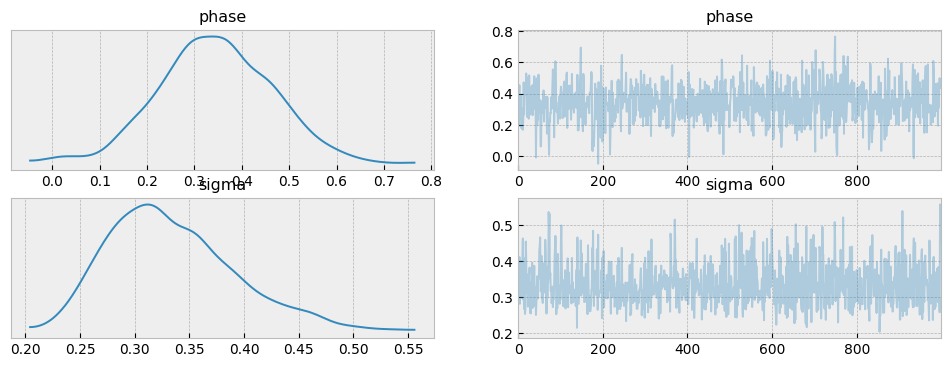

In [60]:
rng_key = jax.random.PRNGKey(0)
nuts_kernel = NUTS(sinusoid_model)
mcmc = MCMC(nuts_kernel, num_warmup=400, num_samples=1000)
mcmc.run(rng_key, x=jnp.asarray(x_obs), y=jnp.asarray(y_obs))
mcmc.print_summary()
az.plot_trace(az.from_numpyro(mcmc), var_names=["phase", "sigma"],
             compact=True, combined=False);

### 予測分布と HPDI


+ 以下のセルで使用する主要な関数・メソッド


  * **`mcmc.get_samples()` — 直前に走らせた MCMC のウォーク結果を Python の辞書として返す。別の `run` を呼ばない限り常に同じ事後サンプル（キー=確率変数名、値=`(num_samples, …)` 形状の `DeviceArray`）を指し示すので、必要なら `dict(...)` などでコピーしておくと安全。**


  * `Predictive(model, posterior_samples)` — NumPyro の予測器クラス。学習済みパラメータサンプル（辞書、または `mcmc.get_samples()` の返り値）を固定しつつ、モデル `model` を再評価して事後予測分布から疑似データを引き出す。第一引数はモデル関数、第二引数はサンプル辞書で、これ以外にも `return_sites` や `parallel` などのオプションを持つ。**内部的には `handlers.condition` などを組み合わせて、元のモデルにサンプル辞書を「条件付き」させた新しいモデルを作っているイメージで、`Predictive(...)` の戻り値はそのラッパーモデルを表す呼び出し可能オブジェクト。こうした「パラメータ固定＋再サンプリング」の挙動は Predictive などハンドラでラップしたとき限定で、元のモデル関数をそのまま呼び出しても乱数は観測できない点に注意。**


  * `jnp.linspace(start, stop, num)` — JAX 版の等間隔ベクトル生成。ここでは 0 から $4\pi$ まで 400 分割した密な入力格子 `x_dense` を作り、連続的な曲線を描くために使う。


  * `predictive(rng_key, x=…, y=None)` — `Predictive` インスタンスを関数のように呼び出すと、指定した乱数キーでモデルを再評価し、辞書形式で疑似観測を返す。ここでは `x` 引数に新しい格子点、`y=None` で観測を固定せずサンプリングモードにする。戻り値の `predictions["y"]` は形状 `(num_samples, len(x_dense))`。


  * `jnp.mean(predictions["y"], axis=0)` — 事後予測サンプルをサンプル次元で平均し、各格子点における事後平均曲線を得る。


  * `hpdi(predictions["y"], prob=0.9)` — NumPyro 付属の HPDI 計算関数。`prob=0.9` で 90% 最高密度区間を返し、戻り値は上下境界をまとめた配列（shape `(2, len(x_dense))`）。**未指定なら `axis=0`（サンプル軸）に沿って区間を計算するので、`predictions["y"]` のように先頭次元にサンプルが並んでいる配列に対しては何も指定しなくてもよい。別の軸で区間を取りたい場合は `axis` を明示する。**


  * `plt.figure`, `plt.plot`, `plt.fill_between`, `plt.legend`, `plt.tight_layout` — Matplotlib の描画 API。新しい図を用意し、観測データ点、事後平均曲線、HPDI の帯域を順に重ね、凡例と軸ラベルを整形して最終的な図をレイアウトする。


+ 事後予測分布は「パラメータの事後分布に従って平均化した将来観測の分布」で、測度の形では


$$p^*(dy\mid x_*, \mathcal{D}) = \int p(dy\mid w, x_*)\, p(dw\mid \mathcal{D})$$


と書ける。ここで $w$ はモデルパラメータ $(\phi, \sigma)$、$\mathcal{D}$ は訓練データ $(x_\text{obs}, y_\text{obs})$。NumPyro の `Predictive` はまさにこの積分をモンテカルロで近似し、`posterior_samples` から $w$ を引き、それぞれについて $p(dy\mid w, x_*)$ をサンプルすることで `$p^*$` の代表値（平均や区間）を構成する。


+ 得られた事後分布サンプル $\{\phi^{(s)}, \sigma^{(s)}\}$ を用いて、任意の入力格子 $x_*$ に対する予測分布


$$y_*^{(s)} \sim \mathcal{N}\bigl(\sin(x_* + \phi^{(s)}), \sigma^{(s)}\bigr)$$


をサンプリングし、平均曲線と 90% HPDI を描く。

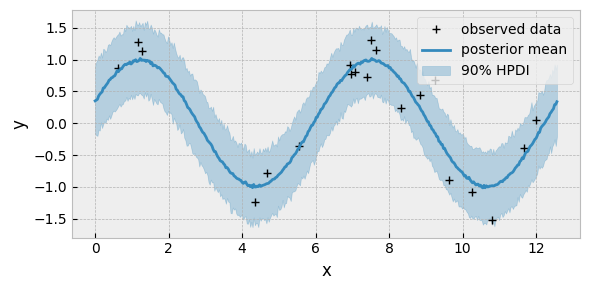

In [61]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(sinusoid_model, posterior_samples)
x_dense = jnp.linspace(0, 4 * jnp.pi, 400)
predictions = predictive(jax.random.PRNGKey(1), x=x_dense, y=None)
mean_curve = jnp.mean(predictions["y"], axis=0)
credible_band = hpdi(predictions["y"], prob=0.9)

plt.figure(figsize=(6, 3))
plt.plot(x_obs, y_obs, "+", color="black", label="observed data")
plt.plot(x_dense, mean_curve, color="C0", label="posterior mean")
plt.fill_between(x_dense, credible_band[0], credible_band[1], color="C0", alpha=0.3, label="90% HPDI")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

In [68]:
predictions['y'].shape

(1000, 400)

### 第7章の発展トピック

以下では書籍の後半で紹介されている追加テクニックを、順に数式とコードで再現する。

#### 7.1.0 モデルの Prior を直接サンプリング


同じ事前分布を用いて、観測を固定せずに


$$d = \sin(x + \phi) + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, \sigma)$$


の `prior predictive` サンプルを得る。handlers を通じて NumPyro モデルから直接サンプリングする。




+ NumPyro の `handlers` モジュールは、モデル関数に「乱数シードを固定する」「既知の値で条件付けする」といったトランスフォームを適用する仕組み。`
  - `handlers.seed(fn, rng_key)` は、モデル（もしくはサンプル生成関数） `fn` に乱数キーを差し込み、戻り値として「乱数が固定された関数」を返す。
  - 返ってきた関数は普通の Python 関数のように呼び出せるので、`handlers.seed(sinusoid_prior_only, prior_key)(x_obs)` のように書けば、`sinusoid_prior_only` が内部で使う NumPyro の乱数キーが `prior_key` に決まり、呼び出しごとに同じ乱数系列で prior サンプルを生成できる。
  - `seed` 以外にも `condition`, `trace`, `substitute` などのハンドラがあり、組み合わせることで複雑な制御やデバッグが可能になる。

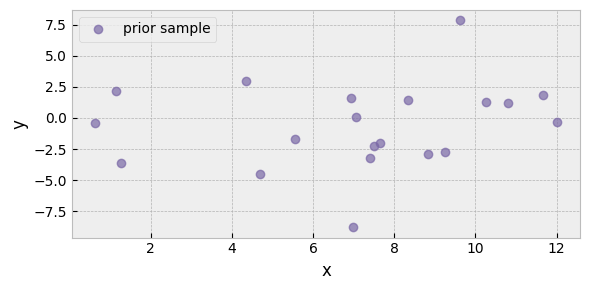

In [71]:
def sinusoid_prior_only(x):
    phase = numpyro.sample("phase", dist.Uniform(-jnp.pi, jnp.pi))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = jnp.sin(x + phase)
    return numpyro.sample("y", dist.Normal(mu, sigma))

prior_key = jax.random.PRNGKey(9)
prior_draws = handlers.seed(sinusoid_prior_only, prior_key)(jnp.asarray(x_obs))

plt.figure(figsize=(6, 3))
plt.plot(x_obs, prior_draws, "o", color="C2", alpha=0.7, label="prior sample")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

#### 7.1 対数尤度を `numpyro.factor` で与える

観測対数尤度

$$\log p(\mathbf{y}\mid \phi, \sigma) = -\tfrac{1}{2}\sum_i \frac{(y_i-\sin(x_i+\phi))^2}{\sigma^2} - N\log \sigma - \tfrac{N}{2}\log(2\pi)$$

を自前で評価し、`numpyro.factor` に渡す形でモデル化する。

+ NumPyro のモデルは、`numpyro.sample` を呼ぶたびにその分布の対数確率が内部の joint log-density に足し込まれる仕組みになっている。`obs` 付きのサンプルであれば、その log-likelihood（定数項を除いた未正規化形でも可）が逐次加算されていき、結果として joint measure $\mu(dx_1, \dots, dx_n)$ の対数が構成される。

+ `numpyro.factor(name, value)` は、その累積 log-density に任意の実数 `value` を追加するためのプリミティブ。従来 `numpyro.sample(..., obs=...)` が自動で足してくれる項を、自分で計算して挿入したいときに使える。正規化定数を含まない未正規化 log-likelihood を足しても問題なく、HMC/NUTS などは log-density の差だけを使ってサンプリングを行う。

+ `.factor` で足し込む log 項の基準となる参照測度（連続変数ならルベーグ、離散なら数え上げなど）は、モデル内で使っている分布と揃えておく必要がある。NumPyro の各 `dist.*` が返す log probability はあらかじめ適切な測度に対して定義されているので、その上に載せるカスタム項でも同じ測度に対する log-density / log-mass を与えることを意識する。これさえ守れば未正規化の差分項を自由に差し込める。

In [70]:
def sinusoid_model_factor(x, y=None):
    phase = numpyro.sample("phase", dist.Uniform(-jnp.pi, jnp.pi))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = jnp.sin(x + phase)
    if y is not None:
        loglike = -0.5 * jnp.square(y - mu) / jnp.square(sigma) - jnp.log(sigma)
        numpyro.factor("loglike", jnp.sum(loglike))

rng_key_factor = jax.random.PRNGKey(1)
mcmc_factor = MCMC(NUTS(sinusoid_model_factor), num_warmup=300, num_samples=500)
mcmc_factor.run(rng_key_factor, x=jnp.asarray(x_obs), y=jnp.asarray(y_obs))
mcmc_factor.print_summary()

sample: 100%|██████████| 800/800 [00:00<00:00, 1358.85it/s, 3 steps of size 1.05e+00. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     phase      0.35      0.11      0.35      0.17      0.54    322.18      1.00
     sigma      0.33      0.05      0.32      0.24      0.41    257.91      1.00

Number of divergences: 0


#### 7.1.1 2種類の観測を同時にフィット

共通の位相 $\phi$ を持つ
$$\begin{aligned}
y_1 &= \sin(x_1 + \phi) + \varepsilon_1,\\
y_2 &= \cos(x_2 + \phi) + \varepsilon_2,\\
\varepsilon_k &\sim \mathcal{N}(0, \sigma)
\end{aligned}$$
を同時に推定し、同じ $\sigma$ を共有させる。

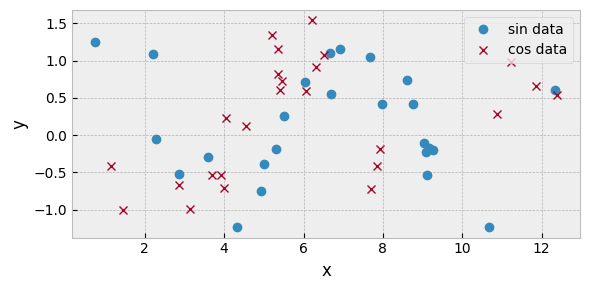

In [15]:
np.random.seed(123)
num_points2 = 25
x1_obs = np.sort(np.random.rand(num_points2)) * 4 * np.pi
x2_obs = np.sort(np.random.rand(num_points2)) * 4 * np.pi
y1_obs = np.sin(x1_obs + phase_true) + np.random.normal(0.0, sigma_true, size=num_points2)
y2_obs = np.cos(x2_obs + phase_true) + np.random.normal(0.0, sigma_true, size=num_points2)

plt.figure(figsize=(6, 3))
plt.plot(x1_obs, y1_obs, "o", color="C0", label="sin data")
plt.plot(x2_obs, y2_obs, "x", color="C1", label="cos data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

In [16]:
def sinusoid_joint_model(x1, x2, y1=None, y2=None):
    phase = numpyro.sample("phase", dist.Uniform(-jnp.pi, jnp.pi))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu1 = jnp.sin(x1 + phase)
    mu2 = jnp.cos(x2 + phase)
    numpyro.sample("y1", dist.Normal(mu1, sigma), obs=y1)
    numpyro.sample("y2", dist.Normal(mu2, sigma), obs=y2)

In [17]:
rng_key_joint = jax.random.PRNGKey(2)
mcmc_joint = MCMC(NUTS(sinusoid_joint_model), num_warmup=400, num_samples=600)
mcmc_joint.run(rng_key_joint, x1=jnp.asarray(x1_obs), x2=jnp.asarray(x2_obs), y1=jnp.asarray(y1_obs), y2=jnp.asarray(y2_obs))
mcmc_joint.print_summary()

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1698.09it/s, 3 steps of size 8.07e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     phase      0.56      0.06      0.57      0.48      0.66    403.42      1.00
     sigma      0.34      0.04      0.34      0.28      0.40    454.30      1.00

Number of divergences: 0


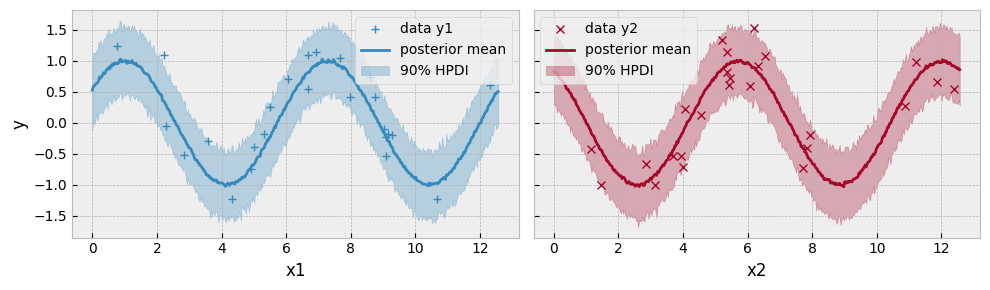

In [18]:
joint_samples = mcmc_joint.get_samples()
predictive_joint = Predictive(sinusoid_joint_model, joint_samples, return_sites=["y1", "y2"])
x1_dense = jnp.linspace(0, 4 * jnp.pi, 400)
x2_dense = jnp.linspace(0, 4 * jnp.pi, 400)
pred_joint = predictive_joint(jax.random.PRNGKey(3), x1=x1_dense, x2=x2_dense, y1=None, y2=None)
mean_y1 = jnp.mean(pred_joint["y1"], axis=0)
hpdi_y1 = hpdi(pred_joint["y1"], prob=0.9)
mean_y2 = jnp.mean(pred_joint["y2"], axis=0)
hpdi_y2 = hpdi(pred_joint["y2"], prob=0.9)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
axes[0].plot(x1_obs, y1_obs, "+", color="C0", label="data y1")
axes[0].plot(x1_dense, mean_y1, color="C0", label="posterior mean")
axes[0].fill_between(x1_dense, hpdi_y1[0], hpdi_y1[1], color="C0", alpha=0.3, label="90% HPDI")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("y")
axes[0].legend()

axes[1].plot(x2_obs, y2_obs, "x", color="C1", label="data y2")
axes[1].plot(x2_dense, mean_y2, color="C1", label="posterior mean")
axes[1].fill_between(x2_dense, hpdi_y2[0], hpdi_y2[1], color="C1", alpha=0.3, label="90% HPDI")
axes[1].set_xlabel("x2")
axes[1].legend()
fig.tight_layout()

#### 7.1.2 補間関数を含むモデル

グリッド点 $(x_a, y_a)$ から補間関数
$$f(x) = \mathrm{interp}(x; x_a, y_a)$$
を作り、$g(x)=A f(x-c)$ を観測モデルに組み込む。補間後も自動微分が通ることを確認する。

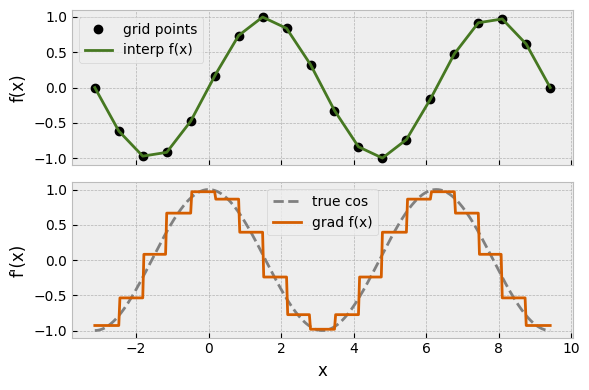

In [20]:
xa = jnp.linspace(-jnp.pi, 3 * jnp.pi, 20)
ya = jnp.sin(xa)
def f_interp(x):
    return jnp.interp(x, xa, ya)

xx = jnp.linspace(-jnp.pi, 3 * jnp.pi, 400)
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
axes[0].plot(xa, ya, "o", color="black", label="grid points")
axes[0].plot(xx, f_interp(xx), color="C3", label="interp f(x)")
axes[0].legend()
axes[0].set_ylabel("f(x)")

df_dx = jax.vmap(jax.grad(f_interp))(xx)
axes[1].plot(xx, jnp.cos(xx), color="gray", linestyle="--", label="true cos")
axes[1].plot(xx, df_dx, color="C4", label="grad f(x)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("f'(x)")
axes[1].legend()
fig.tight_layout()

補間した $f(x)$ を用いて
$$y = A f(x-c) + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, \sigma)$$
というモデルを構築し、$A, c, \sigma$ を NumPyro で推定する。

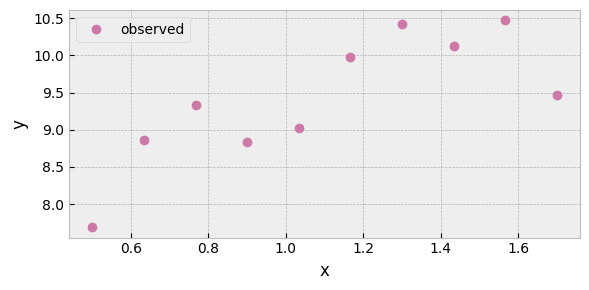

In [21]:
rng_interp = np.random.default_rng(2024)
xb = jnp.linspace(0.5, 1.7, 10)
c_true = 0.3
A_true = 10.0
sigma_true_interp = 0.5
yb = A_true * jnp.sin(xb + c_true) + rng_interp.normal(0.0, sigma_true_interp, size=xb.shape)

plt.figure(figsize=(6, 3))
plt.plot(xb, yb, "o", color="C5", label="observed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

In [22]:
def interpolated_model(x, y=None):
    c = numpyro.sample("c", dist.Uniform(-0.5, 0.5))
    A = numpyro.sample("A", dist.Uniform(0.1, 100.0))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = A * f_interp(x + c)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1471.17it/s, 3 steps of size 7.24e-01. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A     10.74      0.27     10.73     10.30     11.16    322.69      1.00
         c      0.27      0.06      0.27      0.16      0.35    259.31      1.00
     sigma      0.67      0.19      0.63      0.38      0.91    267.08      1.00

Number of divergences: 0


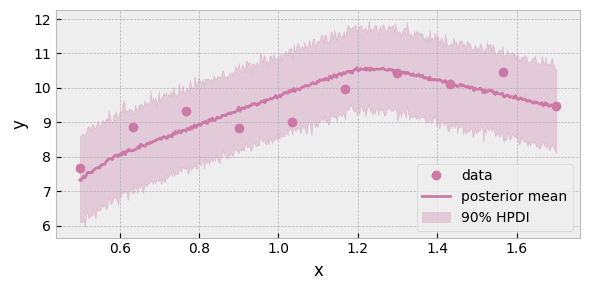

In [23]:
rng_key_interp = jax.random.PRNGKey(4)
mcmc_interp = MCMC(NUTS(interpolated_model), num_warmup=400, num_samples=600)
mcmc_interp.run(rng_key_interp, x=xb, y=yb)
mcmc_interp.print_summary()

interp_samples = mcmc_interp.get_samples()
predictive_interp = Predictive(interpolated_model, interp_samples)
xb_dense = jnp.linspace(xb.min(), xb.max(), 400)
pred_interp = predictive_interp(jax.random.PRNGKey(5), x=xb_dense, y=None)
mean_interp = jnp.mean(pred_interp["y"], axis=0)
hpdi_interp = hpdi(pred_interp["y"], prob=0.9)

plt.figure(figsize=(6, 3))
plt.plot(xb, yb, "o", color="C5", label="data")
plt.plot(xb_dense, mean_interp, color="C5", label="posterior mean")
plt.fill_between(xb_dense, hpdi_interp[0], hpdi_interp[1], color="C5", alpha=0.3, label="90% HPDI")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

#### 7.1.3 畳み込み幅の推定

デルタ列 $y_p$ を既知のガウスカーネル
$$k(t;\sigma_k) = \frac{1}{\sqrt{2\pi}\sigma_k} \exp\left(-\frac{t^2}{2\sigma_k^2}\right)$$
で畳み込んだ観測を用いて、カーネル幅 $\sigma_k$ とノイズ幅 $\sigma$ を同時に推定する。

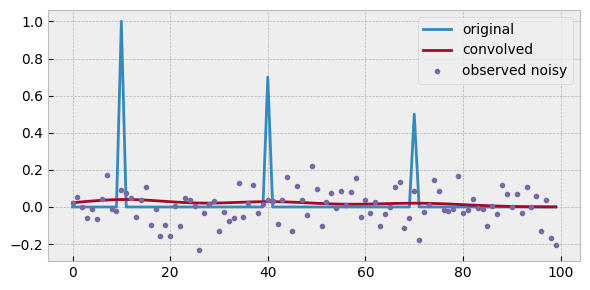

In [25]:
Nk = 100
x_kernel = jnp.linspace(-0.1, 0.1, Nk)
yp = jnp.zeros(Nk)
yp = yp.at[jnp.array([10, 40, 70])].set(jnp.array([1.0, 0.7, 0.5]))
sigma_kernel_true = 0.02
sigma_obs_true = 0.1
kernel_true = jnp.exp(-jnp.square(x_kernel) / (2.0 * sigma_kernel_true**2)) / (jnp.sqrt(2.0 * jnp.pi) * sigma_kernel_true) * (0.2 / Nk)
conv_true = jnp.convolve(yp, kernel_true, mode="same")
rng_conv = np.random.default_rng(7)
y_obs_conv = conv_true + rng_conv.normal(0.0, sigma_obs_true, size=conv_true.shape)

plt.figure(figsize=(6, 3))
plt.plot(yp, label="original")
plt.plot(conv_true, label="convolved")
plt.plot(y_obs_conv, ".", label="observed noisy")
plt.legend()
plt.tight_layout()

In [26]:
def convolution_model(y, xp):
    sigk = numpyro.sample("sigk", dist.Exponential(1.0))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    kernel = jnp.exp(-jnp.square(x_kernel) / (2.0 * sigk**2)) / (jnp.sqrt(2.0 * jnp.pi) * sigk) * (0.2 / Nk)
    mu = jnp.convolve(y, kernel, mode="same")
    numpyro.sample("y", dist.Normal(mu, sigma), obs=xp)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1513.78it/s, 1 steps of size 8.23e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      sigk      1.07      0.95      0.76      0.02      2.50    320.84      1.00
     sigma      0.09      0.01      0.09      0.08      0.10    578.28      1.00

Number of divergences: 0


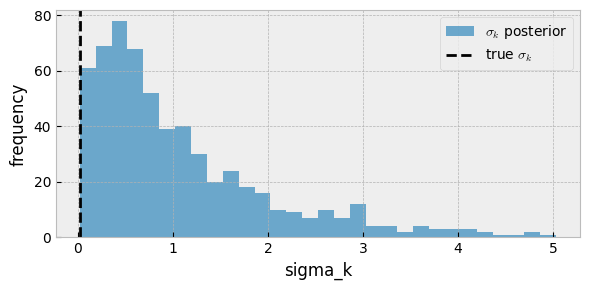

In [27]:
rng_key_conv = jax.random.PRNGKey(6)
mcmc_conv = MCMC(NUTS(convolution_model), num_warmup=400, num_samples=600)
mcmc_conv.run(rng_key_conv, y=yp, xp=y_obs_conv)
mcmc_conv.print_summary()

conv_samples = mcmc_conv.get_samples()
sigk_posterior = np.asarray(conv_samples["sigk"])
sigma_posterior = np.asarray(conv_samples["sigma"])

plt.figure(figsize=(6, 3))
plt.hist(sigk_posterior, bins=30, alpha=0.7, label="$\sigma_k$ posterior")
plt.axvline(sigma_kernel_true, color="k", linestyle="--", label="true $\sigma_k$")
plt.xlabel("sigma_k")
plt.ylabel("frequency")
plt.legend()
plt.tight_layout()

#### 7.2 カスタム自動微分を HMC に統合

$h(x,A)=A\sin x$ に対してカスタム VJP を定義し、
$$y_i = h(x_i - x_0, A) + \varepsilon_i, \qquad \varepsilon_i \sim \mathcal{N}(0, \sigma)$$
というモデルを NumPyro の NUTS で推定する。

In [28]:
@jax.custom_vjp
def h_custom(x, A):
    return A * jnp.sin(x)

def h_custom_fwd(x, A):
    primal = h_custom(x, A)
    aux = (A * jnp.cos(x), jnp.sin(x))
    return primal, aux

def h_custom_bwd(aux, u):
    A_cos_x, sin_x = aux
    return (A_cos_x * u, sin_x * u)

h_custom.defvjp(h_custom_fwd, h_custom_bwd)

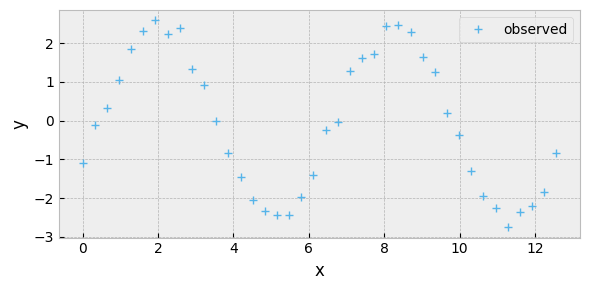

In [29]:
rng_custom = np.random.default_rng(321)
x_custom = jnp.linspace(0.0, 4 * jnp.pi, 40)
A_true_custom = 2.5
x0_true_custom = 0.4
sigma_true_custom = 0.2
y_custom = A_true_custom * jnp.sin(x_custom - x0_true_custom) + rng_custom.normal(0.0, sigma_true_custom, size=x_custom.shape)

plt.figure(figsize=(6, 3))
plt.plot(x_custom, y_custom, "+", color="C6", label="observed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

In [30]:
def custom_vjp_model(x, y=None):
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    x0 = numpyro.sample("x0", dist.Uniform(-1.0, 1.0))
    A = numpyro.sample("A", dist.Exponential(1.0))
    hv = jax.vmap(h_custom, (0, None))(x - x0, A)
    numpyro.sample("y", dist.Normal(hv, sigma), obs=y)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1615.12it/s, 3 steps of size 6.63e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      2.49      0.04      2.49      2.43      2.55    397.44      1.00
     sigma      0.18      0.02      0.17      0.14      0.21    538.24      1.00
        x0      0.41      0.02      0.41      0.38      0.43    488.60      1.00

Number of divergences: 0


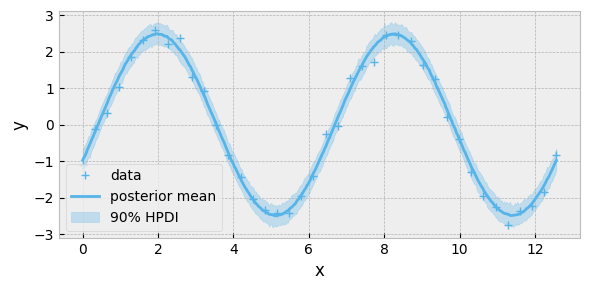

In [31]:
rng_key_custom = jax.random.PRNGKey(7)
mcmc_custom = MCMC(NUTS(custom_vjp_model), num_warmup=400, num_samples=600)
mcmc_custom.run(rng_key_custom, x=x_custom, y=y_custom)
mcmc_custom.print_summary()

custom_samples = mcmc_custom.get_samples()
predictive_custom = Predictive(custom_vjp_model, custom_samples)
x_dense_custom = jnp.linspace(x_custom.min(), x_custom.max(), 400)
pred_custom = predictive_custom(jax.random.PRNGKey(8), x=x_dense_custom, y=None)
mean_custom = jnp.mean(pred_custom["y"], axis=0)
hpdi_custom = hpdi(pred_custom["y"], prob=0.9)

plt.figure(figsize=(6, 3))
plt.plot(x_custom, y_custom, "+", color="C6", label="data")
plt.plot(x_dense_custom, mean_custom, color="C6", label="posterior mean")
plt.fill_between(x_dense_custom, hpdi_custom[0], hpdi_custom[1], color="C6", alpha=0.3, label="90% HPDI")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()